In [1]:
import collections
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import PIPPET
import utils

In [3]:
TWO_PI = 2*np.pi

In [4]:
#%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

plt.style.use('default')
  
DPI = 600
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = DPI
plt.rcParams['figure.autolayout'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
sns.set_context('paper', font_scale=0.9)

## Utility Functions (_scroll down_)

### Tap extraction/analysis

In [4]:
def ts_self_other(m):
    ts_self, ts_other = [0.0], [0.0]
    for i in sorted(m.event_stream.keys()):
        t_i = m.ts[i]
        if 0 in m.event_stream[i]:
            ts_self.append(t_i)
        if 1 in m.event_stream[i]:
            ts_other.append(t_i)
    return ts_self, ts_other

def ioi_self_other(m):
    ts_self, ts_other = ts_self_other(m)
    return np.diff(ts_self), np.diff(ts_other)

In [5]:
def xcorr(x, y, normed=True, detrend=False, maxlags=10):
    # Cross correlation of two signals of equal length
    # Returns the coefficients when normed=True
    # Returns inner products when normed=False
    # Usage: lags, c = xcorr(x,y,maxlags=len(x)-1)
    # Optional detrending e.g. mlab.detrend_mean
    # CREDIT: https://github.com/colizoli/xcorr_python/blob/master/xcorr.py

    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')
    
    if detrend:
        x = x - np.mean(x)
        y = y - np.mean(y)
    
    c = np.correlate(x, y, mode='full')

    if normed:
        n = np.sqrt(np.dot(x, x) * np.dot(y, y)) # this is the transformation function
        c = np.true_divide(c,n)

    if maxlags is None:
        maxlags = Nx - 1
    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maglags must be None or strictly '
                         'positive < %d' % Nx)

    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    return lags, c

def autocorr_m1_0_p1(xs, ys):
    return xcorr(xs, ys, detrend=True, normed=True, maxlags=1)[1]

In [6]:
def _plot_iois(m1):
    ioi_self, ioi_other = ioi_self_other(m1)
    plt.figure(figsize=(8,3))
    plt.plot(np.arange(ioi_self.size), ioi_self/10, '-o', label=m1.labels[0])
    plt.plot(np.arange(ioi_other.size), ioi_other/10, '-o', label=m1.labels[1])
    plt.axhline(TWO_PI/10, c='k', ls='--', alpha=0.25)
    plt.legend(loc='lower left')
    plt.ylabel('Inter-Tap Interval (s)')
    plt.xlabel('Tap #')
    plt.show()

### Online oscPIPPET (for dynamic event generation)

In [7]:
def _step(m, i):
    z_prev = m.z_s[i-1]
    mu_prev = m.mu_s[i-1]
    V_prev = m.V_s[i-1]
    z = m.step(i, z_prev, mu_prev, V_prev)
    z_norm = abs(z)
    if z_norm>=1:
        z = z/z_norm * 0.9999
        print('znorm '+str(z_norm))
    mu, V = PIPPET.PIPPETStream.z_mu_V(z)
    return mu, V, mu_prev, V_prev

def _integrate(m, i, mu, V):
    z = m.streams[0].z_hat(mu, V, m.streams[0].zlambda(mu, V, m.params.tau), m.params.tau)
    m.idx_event.add(i)
    mu, V = PIPPET.PIPPETStream.z_mu_V(z)
    return mu, V

def _update(m, i, mu, V, noise=False):
    if noise:
        mu += np.sqrt(m.params.dt) * m.params.eta_mu * np.random.randn()
        V *= np.exp(np.sqrt(m.params.dt) * m.params.eta_V * np.random.randn())
    m.mu_s[i], m.V_s[i] = mu, V
    m.z_s[i] = np.exp(complex(-V/2, mu))

# Model+Metronome

In [8]:
p = PIPPET.PIPPETParams()
p.dt = 0.01
p.overtime = np.pi/2
p.lambda_0 = 0.0001
p.sigma_phi = .08#0.125
p.mu_0 = 0
p.V_0 = np.pi/5
p.eta_mu = 0.00
p.eta_e = 0.0
p.eta_V = 0.00

In [9]:
def _model_o(e_var_self, e_var_other, e_times_other):
    p_ = copy.deepcopy(p)
    e_var_self    = np.array([e_var_self])
    e_lambda_self = np.array([0.1])
    p_.add(np.array([TWO_PI]), np.array([0.0]), e_var_self, e_lambda_self, p_.lambda_0, 'Self')
    e_var_other    = np.array([e_var_other])
    e_lambda_other = np.array([0.1])
    p_.add(e_times_other, np.array([0.0]), e_var_other, e_lambda_other, p_.lambda_0, 'Other')
    return PIPPET.cPIPPET(p_)

In [10]:
def _run(e_var_self, e_var_other, e_times_nome, start_tapping):

    m_ = _model_o(e_var_self, e_var_other, e_times_nome)

    # Index of 'self' event stream
    s_i_self = m_.labels.index('Self')

    # Simulate
    for i in range(1, m_.n_ts):
        # Update posterior
        mu, V, _, _ = _step(m_, i)
        # Check if it's time to initiate a tap, and forward generate a 'self' event
        n_taps = m_.streams[s_i_self].e_times_p.size
        if mu > -2 and mu<-1 and m_.event_n[s_i_self] == n_taps and m_.ts[i]>start_tapping:
            #print('t=' + str(m_.ts[i]))
            
            t_tap = m_.ts[i] + (0 - mu)
            #print('t_tap=' + str(t_tap))
            #print('pretap events: '+str(m_.streams[s_i_self].e_times_p))
            m_.streams[s_i_self].e_times_p = np.insert(m_.streams[0].e_times_p, n_taps, t_tap)
        _update(m_, i, mu, V, noise=True)

    return m_

### Phase shift examples

In [11]:
shifts = [100, 20, -10, -100]
models = []
asyncs = []
e_var_self = 0.08
e_var_other = 0.05
for i in range(len(shifts)):
    e_times_nome = np.append(np.append(np.arange(1, 4)*TWO_PI, (4+ shifts[i]/500)*TWO_PI), np.arange(5, 10)*TWO_PI )
    start_tapping = 29
    m_ = _run(e_var_self, e_var_other, e_times_nome, start_tapping)
    models.append(m_)
    ts_self, ts_other = ts_self_other(m_)
    async_indices = [i for i, x in enumerate(ts_other) if ts_other[i]>start_tapping]
    first_index = async_indices[0]
    all_ts_self = np.append(np.nan*np.zeros(first_index), ts_self[2:])
    print(all_ts_self)
    print(ts_other)
    this_async = 500/TWO_PI*(np.array(all_ts_self)-np.array(ts_other))
    #this_async[4] = 0
    asyncs.append(this_async)

print(np.append(np.arange(1, 4)*TWO_PI, np.arange(5, 9)*TWO_PI + shifts[i]/500*TWO_PI))
    
    
    
    

s = 0 t = 6.29 znorm 0.96481780682749996897
s = 1 t = 6.29 znorm 0.9853818950535348683
s = 1 t = 12.57 znorm 0.98554249456065545884
s = 1 t = 18.85 znorm 0.9855725041863521832
s = 1 t = 26.39 znorm 0.96612348738386677065
s = 1 t = 31.42 znorm 0.98347219446244726573
s = 0 t = 32.13 znorm 0.9869967462384990177
s = 1 t = 37.7 znorm 0.9864325434123439768
s = 0 t = 38.1 znorm 0.98898080830934082376
s = 1 t = 43.99 znorm 0.9866042376589410923
s = 0 t = 44.22 znorm 0.98943033967478078106
s = 1 t = 50.27 znorm 0.9865468273317376696
s = 0 t = 50.410000000000004 znorm 0.9896025789377718514
s = 1 t = 56.550000000000004 znorm 0.98648760990168173524
s = 0 t = 56.64 znorm 0.98968620358018267433
[  nan   nan   nan   nan   nan 32.13 38.1  44.22 50.41 56.64]
[0.0, 6.29, 12.57, 18.85, 26.39, 31.42, 37.7, 43.99, 50.27, 56.550000000000004]
s = 0 t = 6.29 znorm 0.96481780682749996897
s = 1 t = 6.29 znorm 0.9853818950535348683
s = 1 t = 12.57 znorm 0.98554249456065545884
s = 1 t = 18.85 znorm 0.985572504186

(-0.9, 0.8)

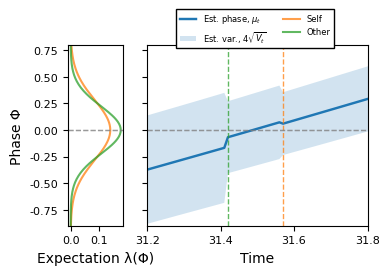

In [12]:
fig, ax1, ax2 = utils.plot_mPIPPET(models[1], wippet=True, figsize=[4, 2.5], xmax=30)
ax2.set_xlim([31.2,31.8])
ax2.set_ylim([-.9, .8])
ax1.set_ylim([-.9, .8])

In [20]:
shifts = [100, 10, -10, -100]

e_var_self = 0.08
e_var_other = 0.05
models2 = []
asyncs2 = []

for i in range(len(shifts)):
    e_times_nome = np.append(np.append(np.arange(1, 4)*TWO_PI, (4+ shifts[i]/500)*TWO_PI), np.arange(5, 10)*TWO_PI )
    start_tapping = 7
    m_ = _run(e_var_self, e_var_other, e_times_nome, start_tapping)

    models2.append(m_)
    ts_self, ts_other = ts_self_other(m_)
    async_indices = [i for i, x in enumerate(ts_other) if ts_other[i]>start_tapping]
    first_index = async_indices[0]
    all_ts_self = np.append(np.nan*np.zeros(first_index), ts_self[2:])
    print(all_ts_self)
    print(ts_other)
    this_async = 500/TWO_PI*(np.array(all_ts_self)-np.array(ts_other))
    this_async[4] = 0
    asyncs2.append(this_async)
 
    

s = 0 t = 6.29 znorm 0.96481780682749996897
s = 1 t = 6.29 znorm 0.9853818950535348683
s = 0 t = 12.57 znorm 0.98154112939193087045
s = 1 t = 12.57 znorm 0.9893804147529522406
s = 0 t = 18.85 znorm 0.98274065570113511926
s = 1 t = 18.85 znorm 0.98978874666337612816
s = 0 t = 25.14 znorm 0.98285058835893999546
s = 1 t = 26.39 znorm 0.9465497205768551935
s = 1 t = 31.42 znorm 0.9818406723302424899
s = 0 t = 31.78 znorm 0.9867662521373357371
s = 1 t = 37.7 znorm 0.9861391647562853092
s = 0 t = 37.89 znorm 0.98926383306520999694
s = 1 t = 43.99 znorm 0.98645776892747721003
s = 0 t = 44.1 znorm 0.98962289744727873565
s = 1 t = 50.27 znorm 0.9864577282957477026
s = 0 t = 50.34 znorm 0.98971661059614996983
s = 1 t = 56.550000000000004 znorm 0.9864334852956235231
s = 0 t = 56.6 znorm 0.98975035015111116675
[  nan   nan 12.57 18.85 25.14 31.78 37.89 44.1  50.34 56.6 ]
[0.0, 6.29, 12.57, 18.85, 26.39, 31.42, 37.7, 43.99, 50.27, 56.550000000000004]
s = 0 t = 6.29 znorm 0.96481780682749996897
s = 

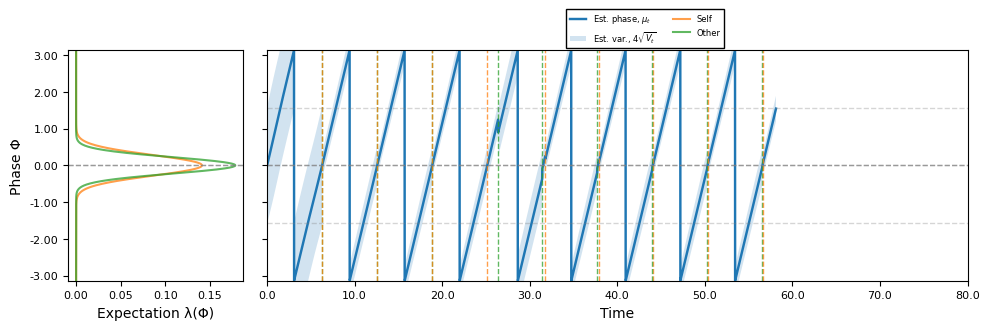

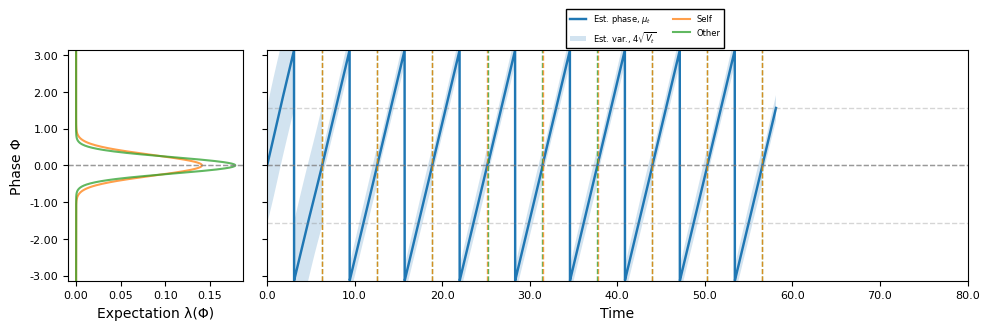

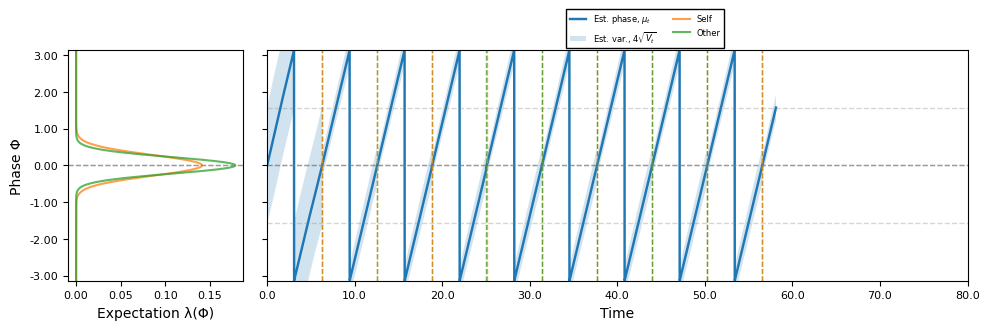

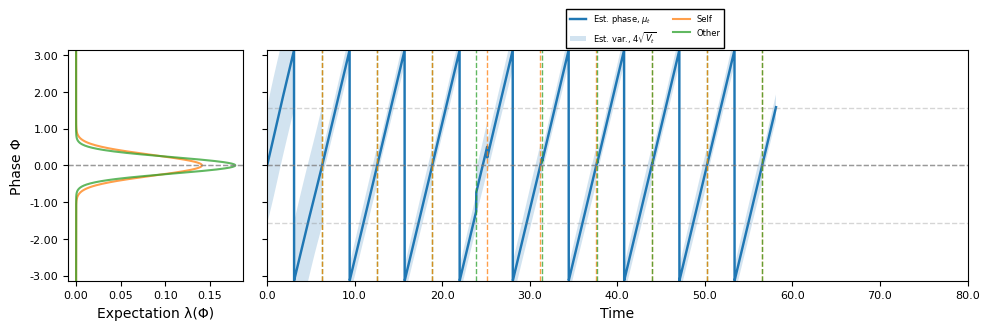

In [22]:
for i in range(len(shifts)):
    fig, ax1, ax2 = utils.plot_mPIPPET(models2[i], wippet=True, figsize=(10, 3), xmax=80)

(-80.0, 100.0)

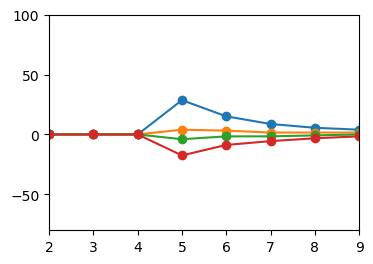

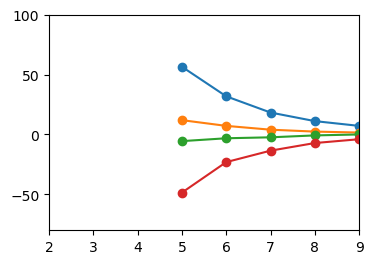

In [21]:
plt.figure(figsize=(4,2.8))

for i in range(len(shifts)):
    plt.plot(np.arange(len(asyncs2[i])), asyncs2[i], '-o')
plt.xlim([2, 9])
plt.ylim([-80, 100])

plt.figure(figsize=(4,2.8))

for i in range(len(shifts)):
    plt.plot(np.arange(len(asyncs[i])), asyncs[i], '-o')
plt.xlim([2, 9])
plt.ylim([-80, 100])



### Grid

In [16]:
e_times_nome = np.arange(1, 20)*TWO_PI
rng = np.random.default_rng(12345)
e_times_trials = [e_times_nome+rng.standard_normal(*e_times_nome.shape)*.1 for _ in range(5)]

In [17]:
steps = 5
models_f = []
for i, e_var_self in enumerate(np.logspace(np.log10(0.005), np.log10(.75*TWO_PI), steps)):
    for j, e_var_other in enumerate(np.logspace(np.log10(0.005), np.log10(.75*TWO_PI), steps)):
        ms_ = []
        for e_ts in e_times_trials:
            m_ = _run(e_var_self, e_var_other, e_ts)
            ms_.append(m_)
        models_f.append(ms_)

TypeError: _run() missing 1 required positional argument: 'start_tapping'

Aggregate coefficients by precision(s):

In [ ]:
recs = []
for ms in models_f:
    for m in ms:
        e_var_self, e_var_other = m.params.templates[0].e_vars[0], m.params.templates[1].e_vars[0]
        ioi_self, ioi_other = ioi_self_other(m)
        rec = [e_var_self, e_var_other] + xcorr(ioi_self, ioi_other, detrend=True, normed=False, maxlags=1)[1].tolist()
        recs.append(rec)
df_f = pd.DataFrame(recs, columns=['v_s', 'v_o', '-1', '0', '+1'])

In [ ]:
df_f.v_s = df_f.v_s.round(3)
df_f.v_o = df_f.v_o.round(3)
df_f = df_f.rename(columns={"v_s": r'$v_{self}$', "v_o": r'$v_{other}$'})
df_f_m = pd.melt(df_f, id_vars=[r'$v_{self}$', r'$v_{other}$'], value_vars=['-1', '0', '+1'], var_name='Lag', value_name='Corr. Coef.')

Report:

In [ ]:
vmin, vmax = -1, 1
vmin, vmax = -.4, .4

In [ ]:
g = sns.catplot(data=df_f_m[(df_f_m['Lag'] == '+1') & (df_f_m[r'$v_{self}$'] < 0.5) & (df_f_m[r'$v_{other}$'] < 1.0)],
                hue=r'$v_{self}$', x=r'$v_{other}$', y='Corr. Coef.', kind='point', ci=None,
                facet_kws={'ylim':[-0.1, 0.4]}, height=4, palette='husl', aspect=1)
axs = g.axes[0]
for ax in axs:
    for v in np.arange(-1, 1.25, .25):
        ax.axhline(v, c='k', ls='--', alpha=0.1)
        
axs[0].set_ylabel('Correlation Coefficient');

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(14, 4))

heatm = lambda lag: df_f_m[df_f_m.Lag == lag].groupby([r'$v_{self}$', r'$v_{other}$']).mean().reset_index().pivot(r'$v_{self}$', r'$v_{other}$', 'Corr. Coef.')
sns.heatmap(heatm('-1'), vmin=vmin, vmax=vmax, ax=axs[0], cmap='viridis')
axs[0].set_title('Lag -1')
sns.heatmap(heatm('0'), vmin=vmin, vmax=vmax, ax=axs[1], cmap='viridis')
axs[1].set_title('Lag 0')
sns.heatmap(heatm('+1'), vmin=vmin, vmax=vmax, ax=axs[2], cmap='viridis')
axs[2].set_title('Lag +1')

f.tight_layout();

# Model+Model

In [ ]:
BEATS = 20

In [ ]:
p = PIPPET.PIPPETParams()
p.dt = 0.01
p.overtime = np.pi/2
p.lambda_0 = 0.00
p.sigma_phi = 0.2
p.mu_0 = 0
p.V_0 = np.pi/5
p.eta_mu = 0.00
p.eta_e = 0.0
p.eta_V = 0.00

In [ ]:
def _run_multi(rng, e_var_self_p1, e_var_other_p1, e_var_self_p2, e_var_other_p2, p1_label, p2_label):
    e_mean   = np.array([0])
    e_lambda = np.array([0.1])
    
    # Add some noise to event timing (i.e. tap time)
    step_noise = lambda: (rng.standard_normal(1) * 0.1)[0]

    # Create two models
    p1 = copy.deepcopy(p)
    p1.add(np.array([TWO_PI*BEATS]), e_mean, e_var_self_p1, e_lambda, p1_label)
    p1.add(np.array([TWO_PI*BEATS]), e_mean, e_var_other_p1, e_lambda, p2_label)
    m1 = PIPPET.oscPIPPET(p1)
    p2 = copy.deepcopy(p)
    p2.add(np.array([TWO_PI*BEATS]), e_mean, e_var_self_p2, e_lambda, p1_label)
    p2.add(np.array([TWO_PI*BEATS]), e_mean, e_var_other_p2, e_lambda, p2_label)
    m2 = PIPPET.oscPIPPET(p2)

    # NOTE: This is horrible code. Why? PIPPET expects an event series, and isn't currently built for dynamic usage...
    # Here I use dummy events above, ts={TWO_PI*BEAT}, to prepare state arrays...
    # .... then regenerate {ts} with the first tap of each model, and {ts} is amended dynamically during runtime.
    t_tap_1 = TWO_PI + p1.mu_0 
    t_tap_2 = TWO_PI + p2.mu_0
    t_tap_1_n = t_tap_1 + step_noise()
    t_tap_2_n = t_tap_2 + step_noise()
    m1.streams[0].params.e_times = np.array([t_tap_1_n])
    m1.streams[0].e_times_p = np.array([t_tap_1_n])
    m1.streams[1].params.e_times = np.array([t_tap_2_n])
    m1.streams[1].e_times_p = np.array([t_tap_2_n])
    m2.streams[0].params.e_times = np.array([t_tap_2_n])
    m2.streams[0].e_times_p = np.array([t_tap_2_n])
    m2.streams[1].params.e_times = np.array([t_tap_1_n])
    m2.streams[1].e_times_p = np.array([t_tap_1_n])

    
    # Simulate
    ts = m1.ts if len(m1.ts) < len(m2.ts) else m2.ts
    n_ts = len(ts)
    tmax = max(ts)
    for i in range(1, n_ts):
        # Calculate new posterior for given timestep, integrating event observations as necessary
        mu1, V1, _, _ = _step(m1, i)
        mu2, V2, _, _ = _step(m2, i)
        # Check if it is tap-initiation-time, then add a "tap" to both models event streams (for self/0 and other/1 respectively)
        n_taps_1 = m1.streams[0].e_times_p.size
        if mu1 > 0.5 and m1.event_n[0] == n_taps_1:
            t_tap = ts[i] + (TWO_PI - mu1) + step_noise()
            m1.streams[0].e_times_p = np.insert(m1.streams[0].e_times_p, n_taps_1, t_tap)
            m2.streams[1].e_times_p = np.insert(m2.streams[1].e_times_p, m2.streams[1].e_times_p.size, t_tap)
        n_taps_2 = m2.streams[0].e_times_p.size
        if mu2 > 0.5 and m2.event_n[0] == n_taps_2:
            t_tap = ts[i] + (TWO_PI - mu2) + step_noise()
            m2.streams[0].e_times_p = np.insert(m2.streams[0].e_times_p, n_taps_2, t_tap)
            m1.streams[1].e_times_p = np.insert(m1.streams[1].e_times_p, m1.streams[1].e_times_p.size, t_tap)
        # Apply noise, if necessary, and update posterior
        _update(m1, i, mu1, V1, noise=True)
        _update(m2, i, mu2, V2, noise=True)

    return m1, m2

### Example

In [18]:
rng = np.random.default_rng(12345)

In [19]:
e_var_self_p1  = np.array([0.15])
e_var_other_p1 = np.array([0.01])
e_var_self_p2  = np.array([0.15])
e_var_other_p2 = np.array([0.01])
p1_label = 'Model A'
p2_label = 'Model B'

m1, m2 = _run_multi(rng, e_var_self_p1, e_var_other_p1, e_var_self_p2, e_var_other_p2, p1_label, p2_label)

NameError: name '_run_multi' is not defined

In [20]:
_plot_iois(m1)

NameError: name 'm1' is not defined

In [21]:
ioi_self, ioi_other = ioi_self_other(m1)
corrs = xcorr(ioi_self, ioi_other, detrend=True, normed=False, maxlags=1)[1]
corrs

NameError: name 'm1' is not defined

In [22]:
fig = utils.plot_mPIPPET(m1, wippet=True, figsize=(12, 3), xmax=20)
fig = utils.plot_mPIPPET(m2, wippet=True, figsize=(12, 3), xmax=20)

NameError: name 'm1' is not defined

### Grid (Mutual Adaptation)

In [23]:
p1_label = 'P1'
p2_label = 'P2'

models = []
steps = 5
for v in np.logspace(np.log10(0.005), np.log10(1.), steps):
    e_var_self_p1  = np.array([0.15])
    e_var_other_p1 = np.array([v])
    e_var_self_p2  = np.array([0.15])
    e_var_other_p2 = np.array([v])
    
    rng = np.random.default_rng(12345)
    
    ms_ = []
    for _ in range(10):
        m1, m2 = _run_multi(rng, e_var_self_p1, e_var_other_p1, e_var_self_p2, e_var_other_p2, p1_label, p2_label)
        ms_.append((m1, m2))
    models.append(ms_)

NameError: name '_run_multi' is not defined

In [24]:
recs = []
for ms_ in models:
    e_var_self, e_var_other = ms_[0][0].params.templates[0].e_vars[0], ms_[0][0].params.templates[1].e_vars[0]
    for m_, _ in ms_:
        ioi_self, ioi_other = ioi_self_other(m_)
        rec = [e_var_self, e_var_other] + xcorr(ioi_self, ioi_other, detrend=True, normed=False, maxlags=1)[1].tolist()
        recs.append(rec) 
df = pd.DataFrame(recs, columns=['v_s', 'v_o', '-1', '0', '+1'])


Aggregate coefficients by precision(s):

In [42]:
df.v_s = df.v_s.round(3)
df.v_o = df.v_o.round(3)
df = df.rename(columns={"v_s": r'$v_{self}$', "v_o": r'$v_{other}$'})
df_m = pd.melt(df, id_vars=[r'$v_{self}$', r'$v_{other}$'], value_vars=['-1', '0', '+1'], var_name='Lag', value_name='Corr. Coef.')

Report:

In [43]:
vmin, vmax = -1, 1

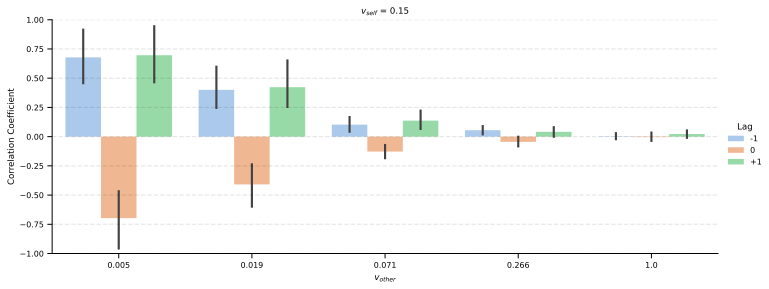

In [44]:
g = sns.catplot(data=df_m, col=r'$v_{self}$', x=r'$v_{other}$', y='Corr. Coef.', hue='Lag', kind='bar', palette='pastel', facet_kws={'ylim':[vmin, vmax]},
                 height=4, aspect=2.5)
axs = g.axes[0]
for ax in axs:
    for v in np.arange(-1, 1.25, .25):
        ax.axhline(v, c='k', ls='--', alpha=0.1)
axs[0].set_ylabel('Correlation Coefficient');